# Prior and Posterior Predictive Checks

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a ‘sense check’ or explaining your model to others and getting criticism.

*Prior* predictive checks are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model – in short, they help you check how credible your assumptions before seeing the data are.
* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

Here, we will implement a general routine to draw samples from the observed nodes of a model. The models are basic but they will be a steppingstone for creating your own routines. If you want to see how to do prior and posterior predictive checks in a more complex, multidimensional model, you can check [this notebook](https://github.com/aloctavodia/BAP/blob/master/extras/multinomial_ppcs.ipynb). Now, let’s sample!

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.special import expit as logistic

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

def standardize(series):
    """Standardize pandas Series"""
    return (series - series.mean()) / series.std()

In [3]:
# Let's generate a simple model for linear regression

N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"



'1.59, 5.69, 4.97, 17.54'

As you can see, variation in our predictor and outcome are quite high – which is often the case with real data. And sometimes, the sampler won’t like this – and you don’t want to make the sampler angry when you’re a Bayesian… So, let’s do what you’ll often have to do with real data: standardize! This way, our predictor and outcome will have a mean of 0 and std of 1, and the sampler will be much, much happier:

In [4]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'0.00, 1.00, -0.00, 1.00'

And now, let’s write the model with conventional flat priors and sample prior predictive samples:



In [5]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


What do these priors mean? It’s always hard to tell on paper – the best is to plot their implication on the outcome scale, like that:



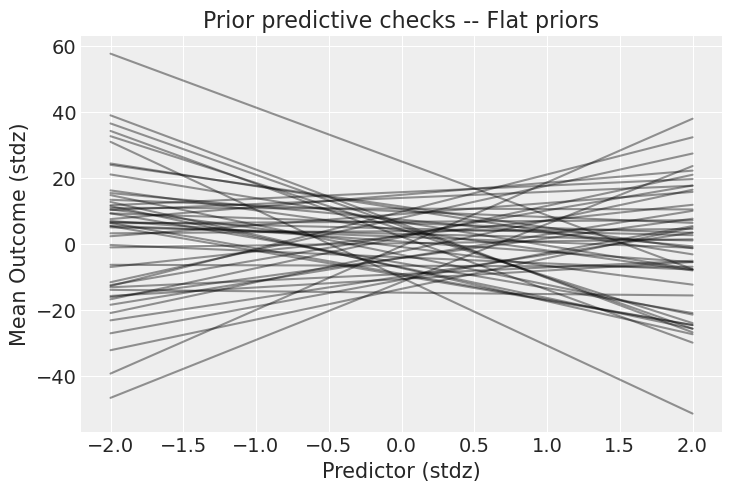

In [7]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2,2,50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), color="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

These priors allow for absurdly strong relationships between the outcome and predictor. Of course, the choice of prior always depends on your model and data, but look at the scale of the y axis: the outcome can go from -40 to +40 standard deviations (remember, the data are standardized). I hope you will agree this is way too permissive – we can do better! Let’s use weakly informative priors and see what they yield. In a real case study, this is the part where you incorporate scientific knowledge into your model:



In [8]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(draws=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


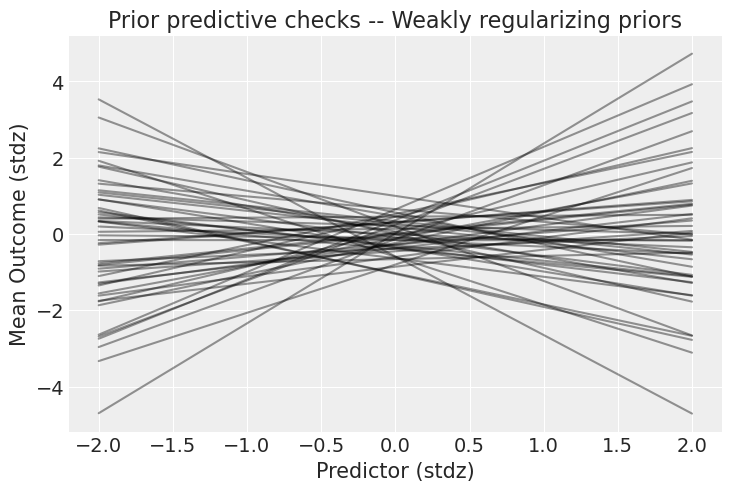

In [9]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Well that’s way better! There are still very strong relationships, but at least now the outcome stays in the realm of possibilities. Now, it’s time to party – if by “party” you mean “run the model”, of course.



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, b, sigma]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 41 seconds.


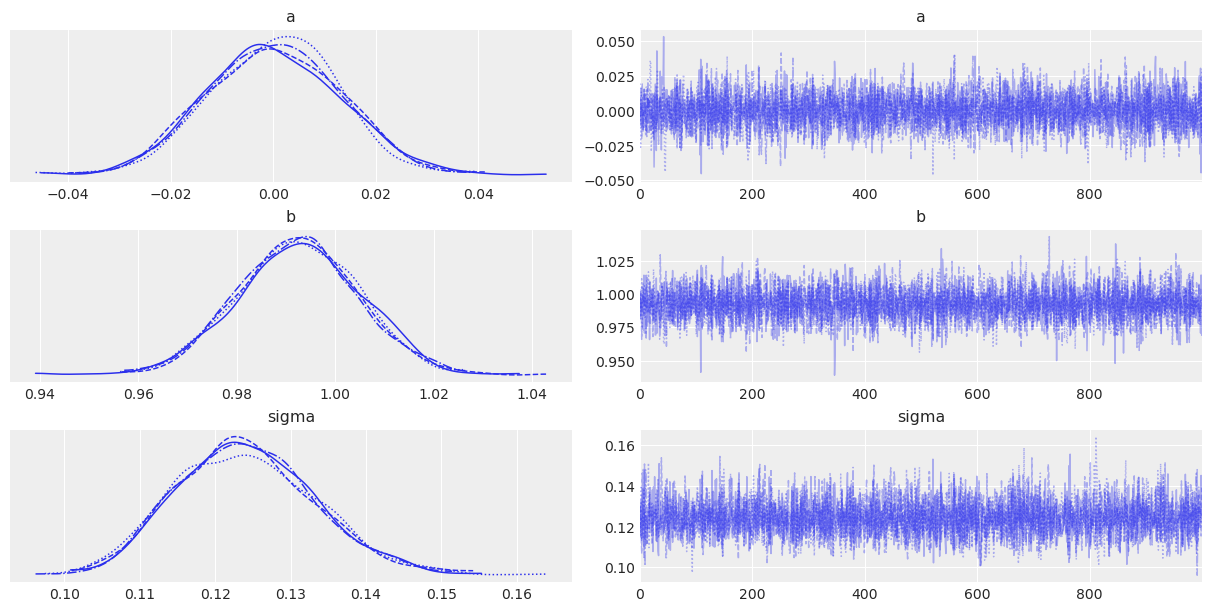

In [10]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng, chains=4))

az.plot_trace(idata);

Everything ran smoothly, but it’s often difficult to understand what the parameters’ values mean when analyzing a trace plot or table summary – even more so here, as the parameters live in the standardized space. A useful thing to understand your models is… you guessed it: posterior predictive checks! We’ll use PyMC’s dedicated function to sample data from the posterior. This function will randomly draw 4000 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of mu and sigma in that sample:



In [11]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Now, the posterior_predictive group in idata contains 4000 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:



In [12]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:    (chain: 4, draw: 1000, obs_dim_0: 100)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_dim_0  (obs_dim_0) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_0) float64 3MB -0.3941 -0.003109 ... 0.7515
Attributes:
    created_at:                 2025-05-14T09:49:46.912424+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

One common way to visualize is to look if the model can reproduce the patterns observed in the real data. ArviZ has a really neat function to do that out of the box:



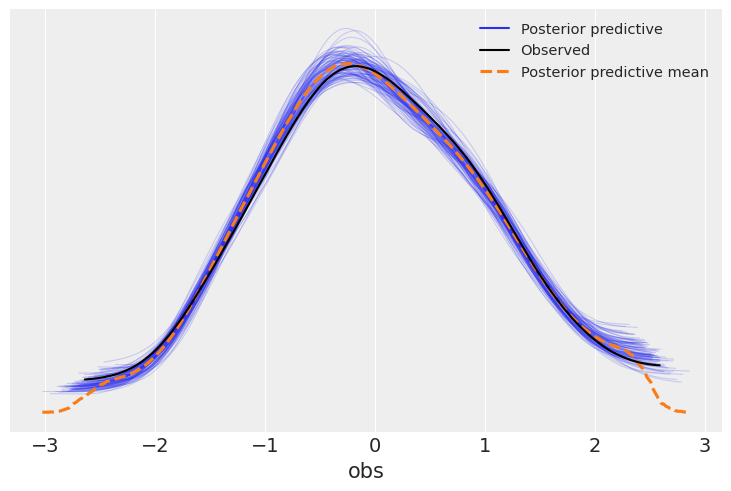

In [13]:
az.plot_ppc(idata, num_pp_samples=100);

It looks like the model is pretty good at retrodicting the data. In addition to this generic function, it’s always nice to make a plot tailored to your use-case. Here, it would be interesting to plot the predicted relationship between the predictor and the outcome. This is quite easy, now that we already sampled posterior predictive samples – we just have to push the parameters through the model:



In [14]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

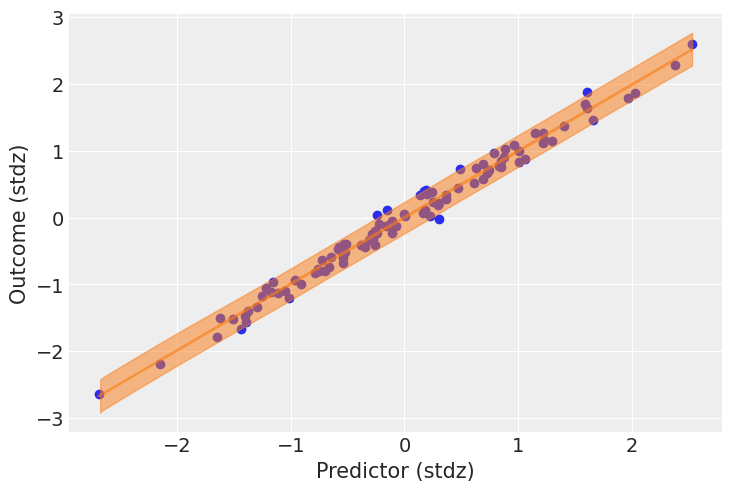

In [15]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

## Prediction

The same pattern can be used for prediction. Here, we are building a logistic regression model:

In [16]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [17]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng, chains=4)
az.summary(idata_2, var_names=["betas"], round_to=2)

/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [betas]


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 31 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.22,0.11,0.03,0.43,0.0,0.0,4002.84,2883.06,1.0
betas[1],1.02,0.14,0.77,1.29,0.0,0.0,4079.89,2670.03,1.0


Now, let’s simulate out-of-sample data to see how the model predicts them. We’ll give the new predictors to the model and it’ll then tell us what it thinks the outcomes are, based on what it learned in the training round. We’ll then compare the model’s predictions to the true out-of-sample outcomes.



In [18]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling: []


/Users/sorenjorgensen/miniconda3/envs/pymc_env/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [19]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

### Mean predicted values plus error bars to give a sense of uncertainty in prediction

Note that since we are dealing with the full posterior, we are also getting uncertainty in our predictions for free.

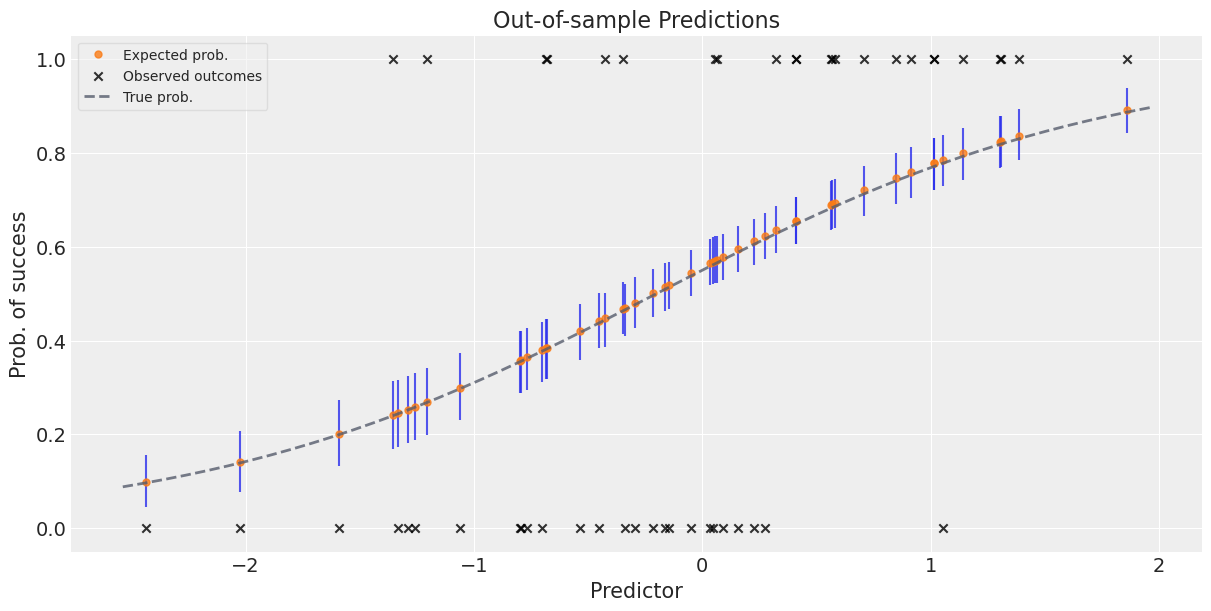

In [20]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);